# Assignment 1

In [1]:
import csv
import math
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
    return round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2))

def read_tsp_instance(file_path):
    nodes = []
    costs = []
    
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        for row in reader:
            x, y, cost = map(int, row)
            nodes.append((x, y))
            costs.append(cost)

    num_nodes = len(nodes)
    
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distance = euclidean_distance(nodes[i][0], nodes[i][1], nodes[j][0], nodes[j][1])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
            
    costs = np.array(costs)
    nodes = np.array(nodes)

    return distance_matrix, costs, nodes

## Reading instances

In [2]:
file_path = 'TSPA.csv'
distance_matrix_a, costs_a, nodes_a = read_tsp_instance(file_path)

In [3]:
file_path = 'TSPB.csv'
distance_matrix_b, costs_b, nodes_b = read_tsp_instance(file_path)

# Problem description

We are given three columns of integers with a row for each node. The first two columns contain x
and y coordinates of the node positions in a plane. The third column contains node costs. The goal is
to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to
be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the
sum of the total length of the path plus the total cost of the selected nodes is minimized.

# Greedy Heuristics Implementations

In [9]:
def calculate_total_cost(solution, distance_matrix, costs):
    total_cost = 0
    for i in range(len(solution) - 1):
        total_cost += distance_matrix[solution[i]][solution[i + 1]] + costs[solution[i]]
    total_cost += distance_matrix[solution[-1]][solution[0]]
    total_cost += costs[solution[-1]]
    return total_cost

Pseudocode of Random Solution
1. Calculate the number of nodes to select
2. Select randomly half of that rounded mathematically
3. Return solution

In [10]:
def random_solution(distance_matrix):
    num_nodes = distance_matrix.shape[0]
    num_nodes_to_select = math.ceil(num_nodes / 2)
    selected_nodes = np.random.choice(num_nodes, num_nodes_to_select, replace=False)
    return selected_nodes

### Nearest neighbor considering adding the node only at the end of the current path

1. Calculate the number of nodes to select
2. Select random node, as the first one
3. Until, you would select a given number of nodes, add nodes to the path, which have the lowest distance to the node at the end of current path (possible improvement, by selecting last node, which have the lowest sum of costs from current node and to the first node)
4. Return solution

In [11]:
def nn_end(distance_matrix):
    num_nodes = len(distance_matrix)
    num_nodes_to_select = np.ceil(num_nodes / 2)
    first_node = np.random.choice(num_nodes)
    selected_nodes = [first_node]
    INT_INF = 10**9
    
    for _ in range(int(num_nodes_to_select) - 1):
        last_node = selected_nodes[-1]
        distances = distance_matrix[last_node]
        for i in selected_nodes:
            distances[i] = INT_INF
        next_node = np.argmin(distances)
        selected_nodes.append(next_node)

    return selected_nodes

### Greedy cycle

The algorithm works as follows:

1. Start by selecting a small cycle, by selecting first node randomly and the first looking for the closest node possibly to the first one.
2. For each remaining node, find the optimal position in the current cycle where inserting this new node results in the smallest increase in total path length.
3. Repeat until all required nodes are added to form a complete cycle.
4. Return solution

In [12]:
def greedy_cycle(distance_matrix):
    num_nodes = len(distance_matrix)
    num_nodes_to_select = np.ceil(num_nodes / 2)
    first_node = np.random.choice(num_nodes)
    second_node = np.argmin(distance_matrix[first_node])
    selected_nodes = [first_node, second_node]
    
    # For each remaining node, find the optimal position in the current cycle where inserting this new node results in the smallest increase in total path length.
    while len(selected_nodes) < num_nodes_to_select:
        min_increase = np.inf
        for i in range(len(selected_nodes) - 1):
            # in pseudocode
            # increase = distance from i to new node + distance from new node to i + 1 - distance from i to i + 1
            increase = distance_matrix[selected_nodes[i]][len(selected_nodes)] + distance_matrix[len(selected_nodes)][selected_nodes[i + 1]] - distance_matrix[selected_nodes[i]][selected_nodes[i + 1]]
            if increase < min_increase:
                min_increase = increase
                position = i + 1
        selected_nodes.insert(position, len(selected_nodes))

    return selected_nodes

# Experiment method 
Results of a computational experiment: for each instance and method min, max and average value of the objective function.

In [13]:
def run_experiment(distance_matrix, costs, algorithm, instance, method_str):
    import matplotlib.pyplot as plt
    min_sol = 0
    max_sol = 0
    avg_sol = 0
    best_solution = None
    num_iterations = 200

    for i in range(num_iterations):
        solution = algorithm(distance_matrix)
        cost = calculate_total_cost(solution, distance_matrix, costs)
        if i == 0:
            min_sol = cost
            max_sol = cost
            avg_sol = cost
            best_solution = solution
        else:
            if cost < min_sol:
                min_sol = cost
                best_solution = solution
            if cost > max_sol:
                max_sol = cost
            avg_sol += cost

    avg_sol /= num_iterations
    
    print(f'{method_str} {instance}:')
    print('Min/Best:', min_sol)
    print('Max:', max_sol)
    print('Avg:', avg_sol)
    
    # plot that values in a form of the bar chart
    plt.bar(['Min', 'Max', 'Avg'], [min_sol, max_sol, avg_sol])
    
    with open(f'{method_str}_{instance}.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(best_solution)
        
    with open('results.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow([method_str, instance, min_sol, max_sol, avg_sol])

    return best_solution

# Visualization 
2D visualization of the best solution for each instance and method. Cost of nodes should be presented e.g. by a color, greyscale, or size.

In [14]:
def plot_solution(nodes, costs, selected_nodes, title):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    
    plt.figure(figsize=(16, 8))

    x = [nodes[i][0] for i in selected_nodes]
    y = [nodes[i][1] for i in selected_nodes]
    c = [costs[i] for i in selected_nodes]
    
    # Plot edges
    for i in range(len(selected_nodes) - 1):
        plt.plot([nodes[selected_nodes[i]][0], nodes[selected_nodes[i + 1]][0]], [nodes[selected_nodes[i]][1], nodes[selected_nodes[i + 1]][1]], 'k-', zorder=1)
    plt.plot([nodes[selected_nodes[-1]][0], nodes[selected_nodes[0]][0]], [nodes[selected_nodes[-1]][1], nodes[selected_nodes[0]][1]], 'k-', zorder=1)

    # Plot nodes
    plt.scatter(x, y, c=c, cmap=cm.gray, s=100, zorder=2) # cividis, inferno, magma, plasma, viridis, gray
    
    # Order Labels
    for i, node_idx in enumerate(selected_nodes):
        plt.text(nodes[node_idx][0], nodes[node_idx][1] + 30, f'{i}', fontsize=12, color='red', ha='center', zorder=3)
        
    plt.title(title)
    
    plt.colorbar()
    plt.show()

# Results for Heuristics

#### Random

random A:
Min/Best: 239289
Max: 288408
Avg: 264092.82


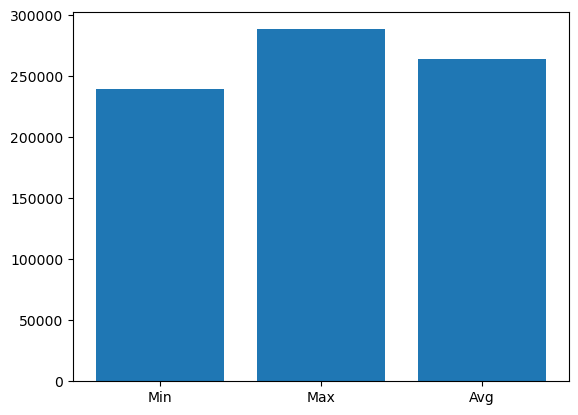

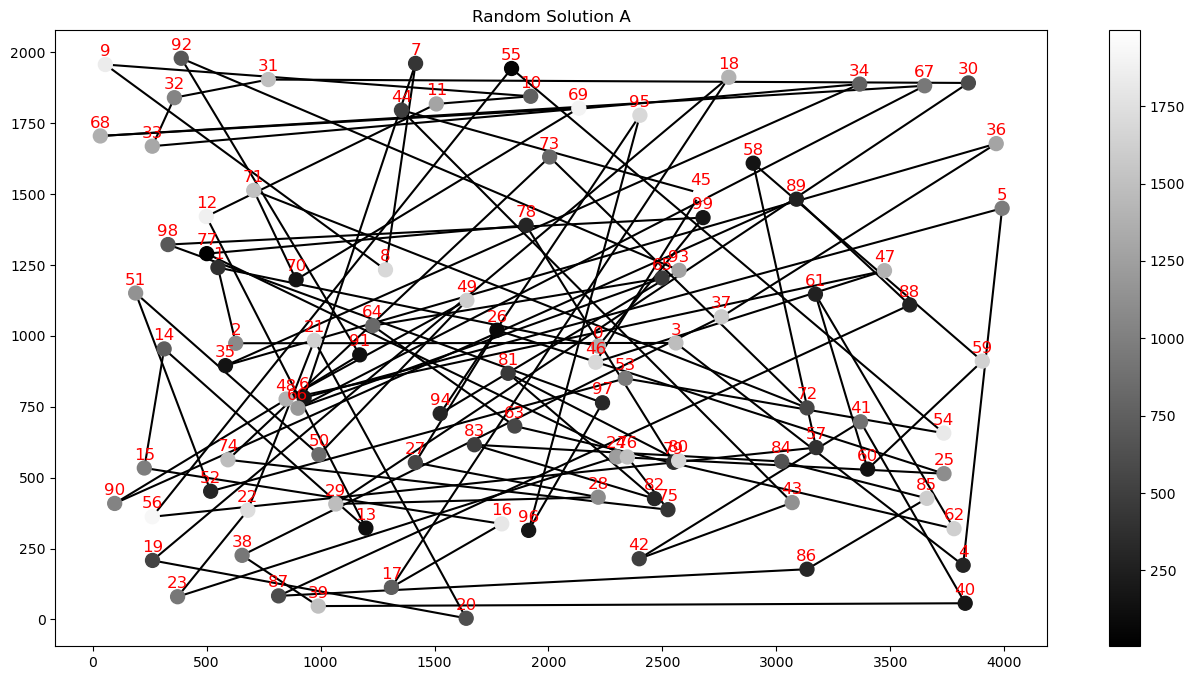

random B:
Min/Best: 191207
Max: 240853
Avg: 214381.355


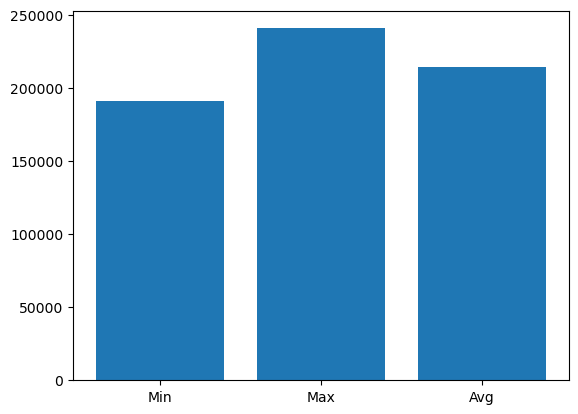

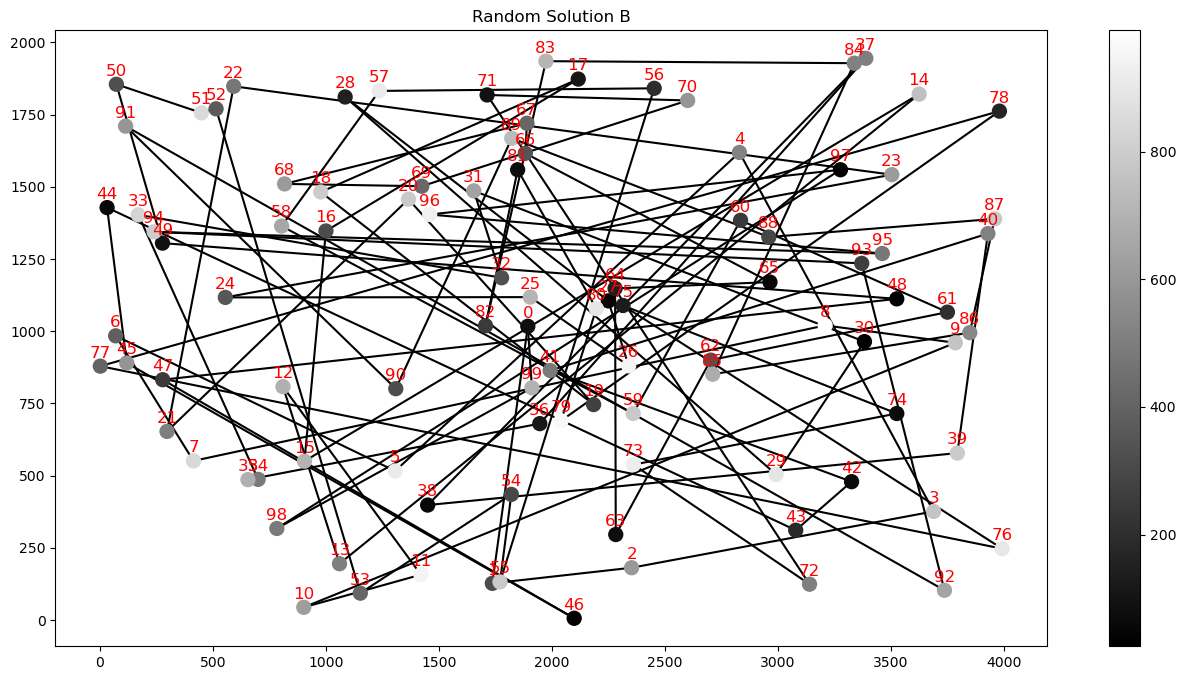

In [15]:
best_solution = run_experiment(distance_matrix_a, costs_a, random_solution, 'A', 'random')
plot_solution(nodes_a, costs_a, best_solution, 'Random Solution A')
best_solution = run_experiment(distance_matrix_b, costs_b, random_solution, 'B', 'random')
plot_solution(nodes_b, costs_b, best_solution, 'Random Solution B')

#### Nearest neighbor considering adding the node only at the end of the current path

nn_end A:
Min/Best: 109424
Max: 119996
Avg: 114301.135


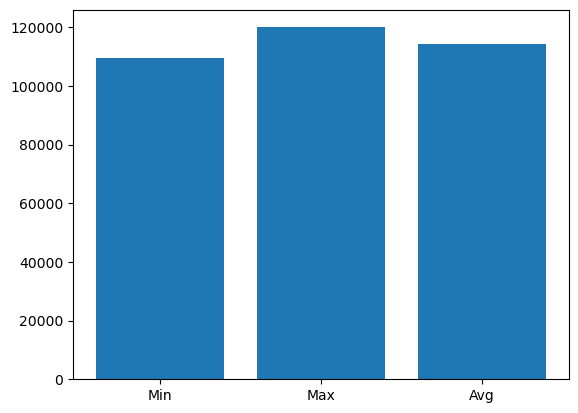

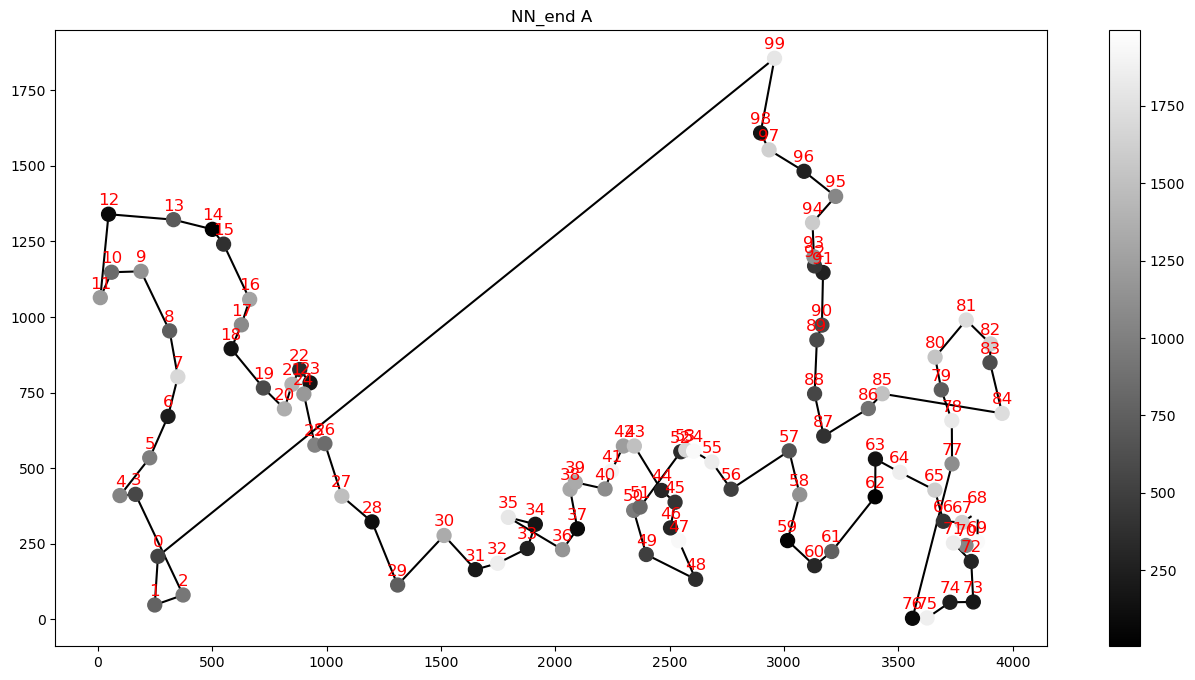

nn_end B:
Min/Best: 65441
Max: 1000076405
Avg: 175073327.025


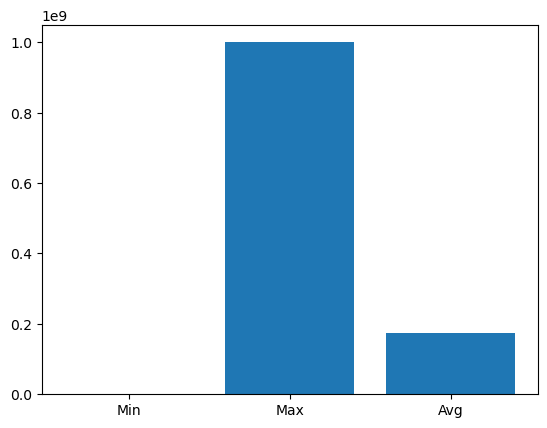

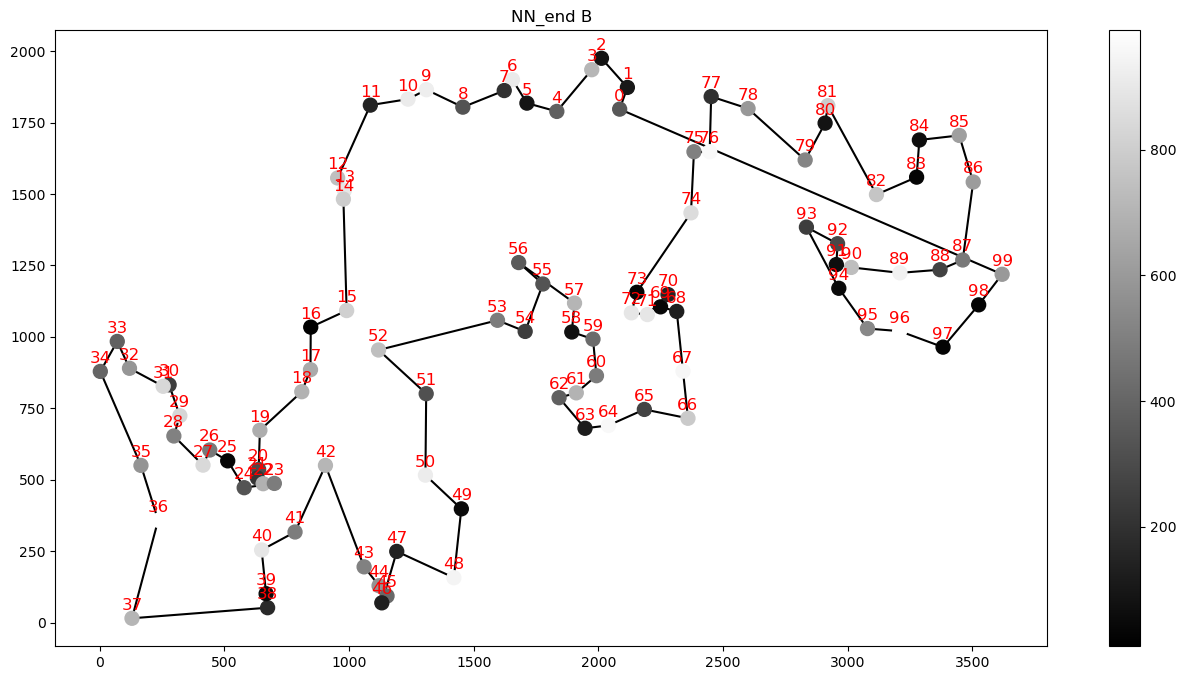

In [16]:
best_solution = run_experiment(distance_matrix_a, costs_a, nn_end, 'A', 'nn_end')
plot_solution(nodes_a, costs_a, best_solution, 'NN_end A')
best_solution = run_experiment(distance_matrix_b, costs_b, nn_end, 'B', 'nn_end')
plot_solution(nodes_b, costs_b, best_solution, 'NN_end B')

#### Greedy cycle

greedy_cycle A:
Min/Best: 134432
Max: 2000134868
Avg: 1650131885.73


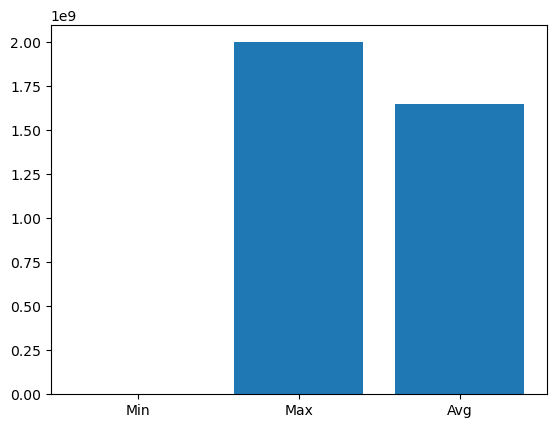

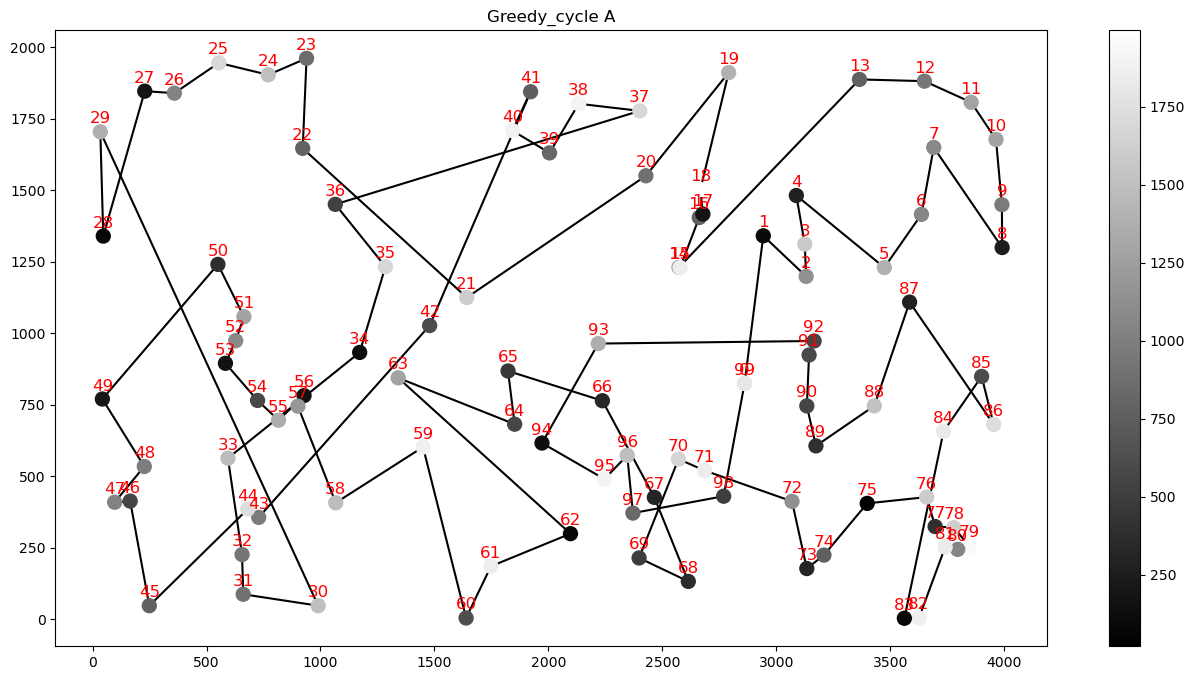

greedy_cycle B:
Min/Best: 67969
Max: 1000076405
Avg: 165073537.475


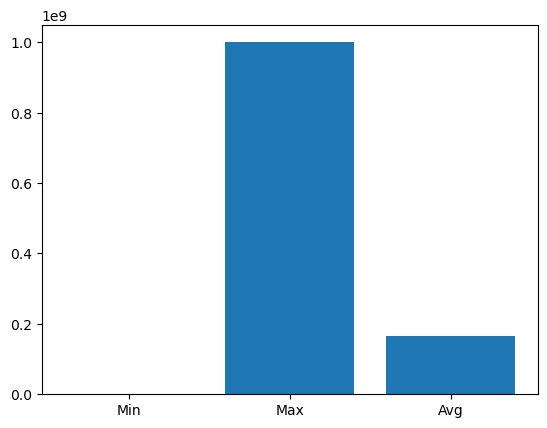

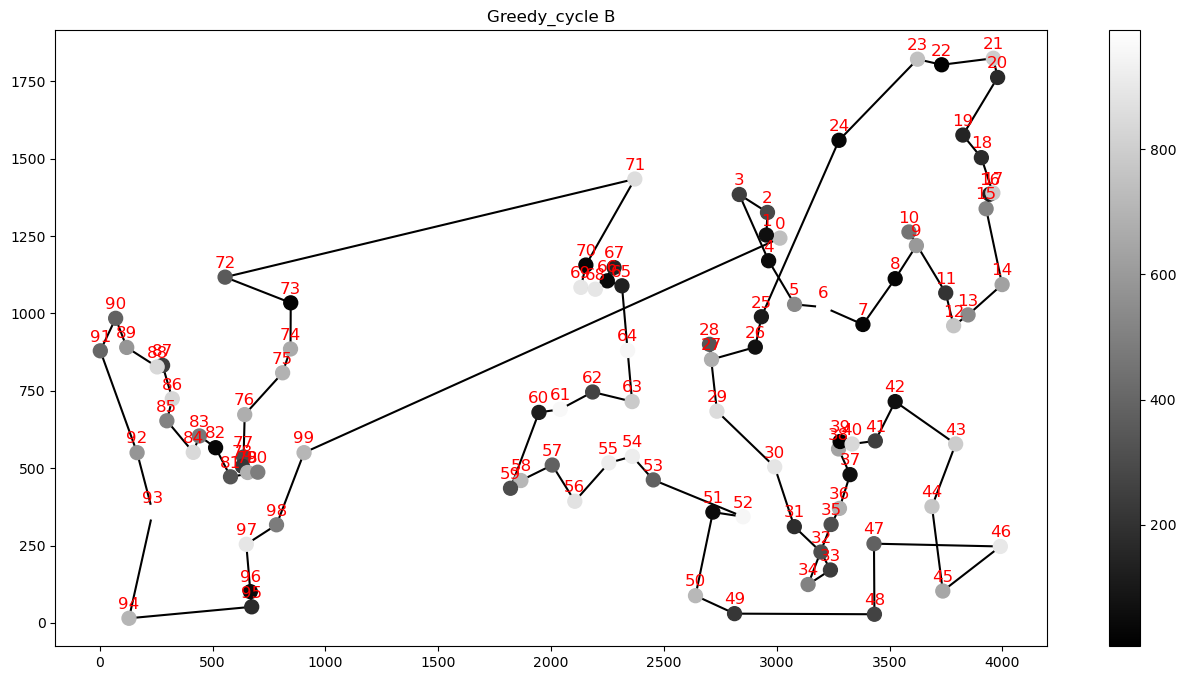

In [17]:
best_solution = run_experiment(distance_matrix_a, costs_a, greedy_cycle, 'A', 'greedy_cycle')
plot_solution(nodes_a, costs_a, best_solution, 'Greedy_cycle A')
best_solution = run_experiment(distance_matrix_b, costs_b, nn_end, 'B', 'greedy_cycle')
plot_solution(nodes_b, costs_b, best_solution, 'Greedy_cycle B')

# Comparison
(All Solutions checked by Solution Solver)

,Method,Instance,Min,Max,Avg
0,random,A,239289,288408,2.640928e+05
2,nn_end,A,109424,119996,1.143011e+05
4,greedy_cycle,A,134432,2000134868,1.650132e+09


,Method,Instance,Min,Max,Avg
1,random,B,191207,240853,2.143814e+05
3,nn_end,B,65441,1000076405,1.750733e+08
5,greedy_cycle,B,67969,1000076405,1.650735e+08


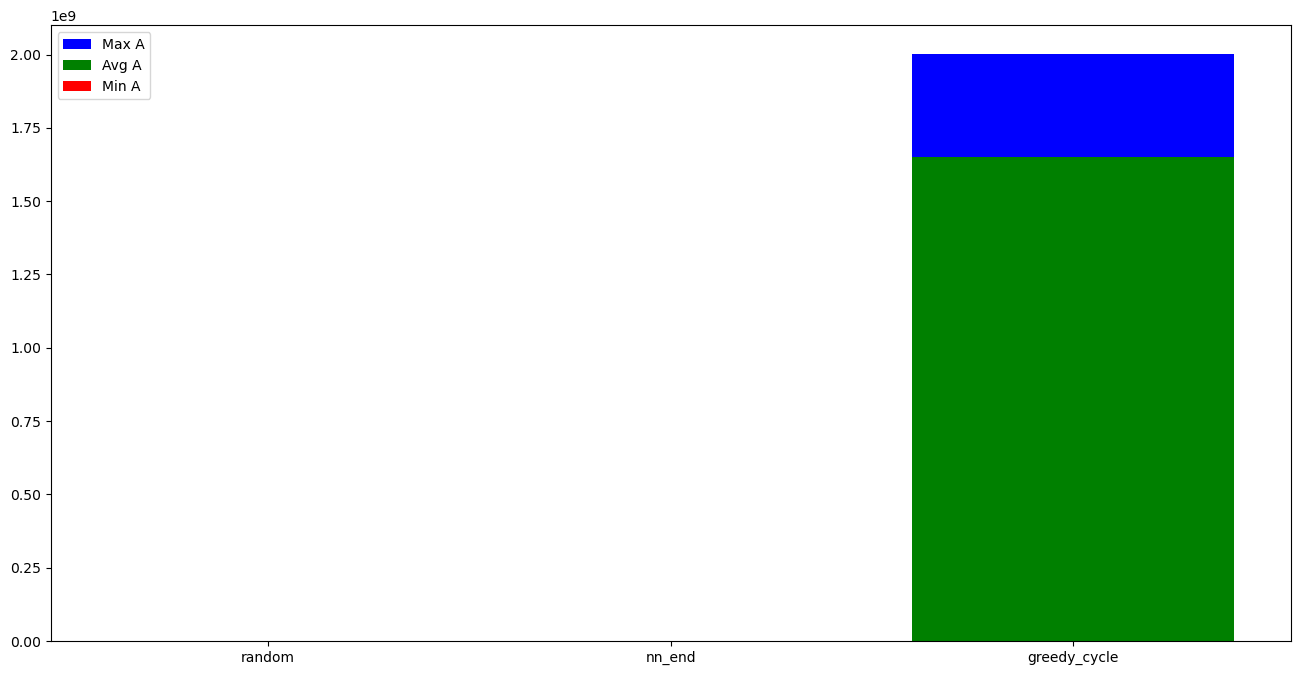

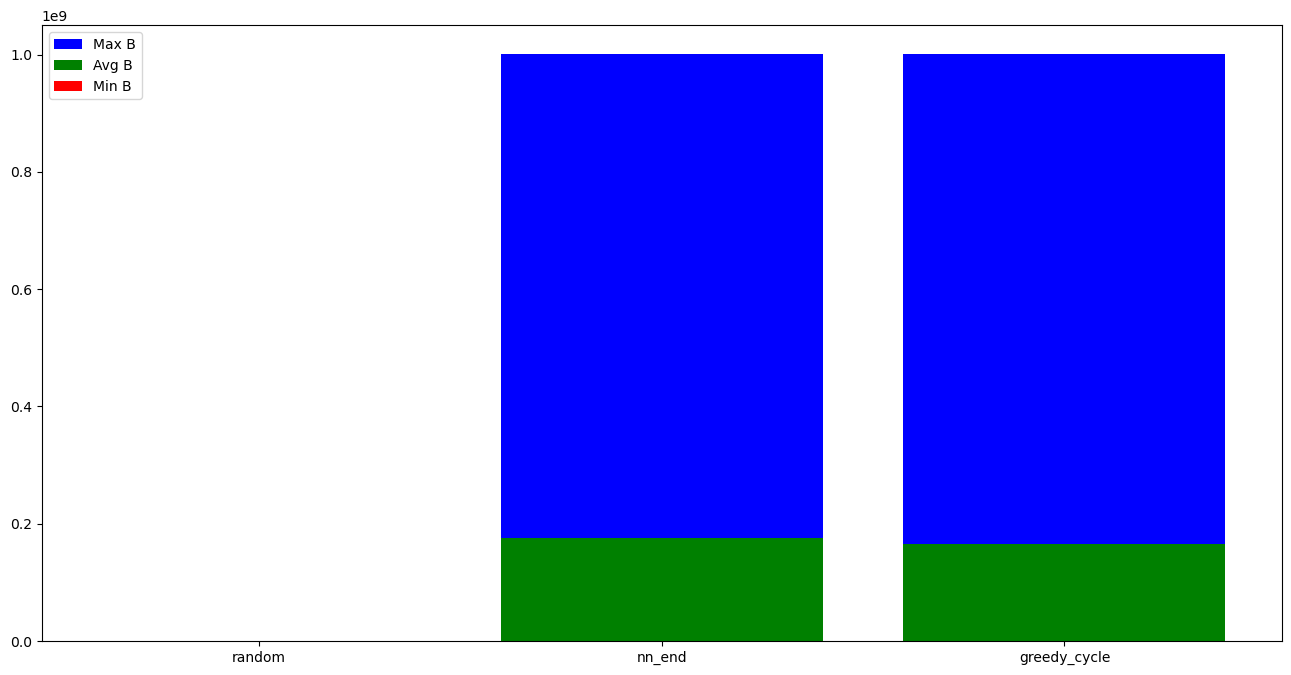

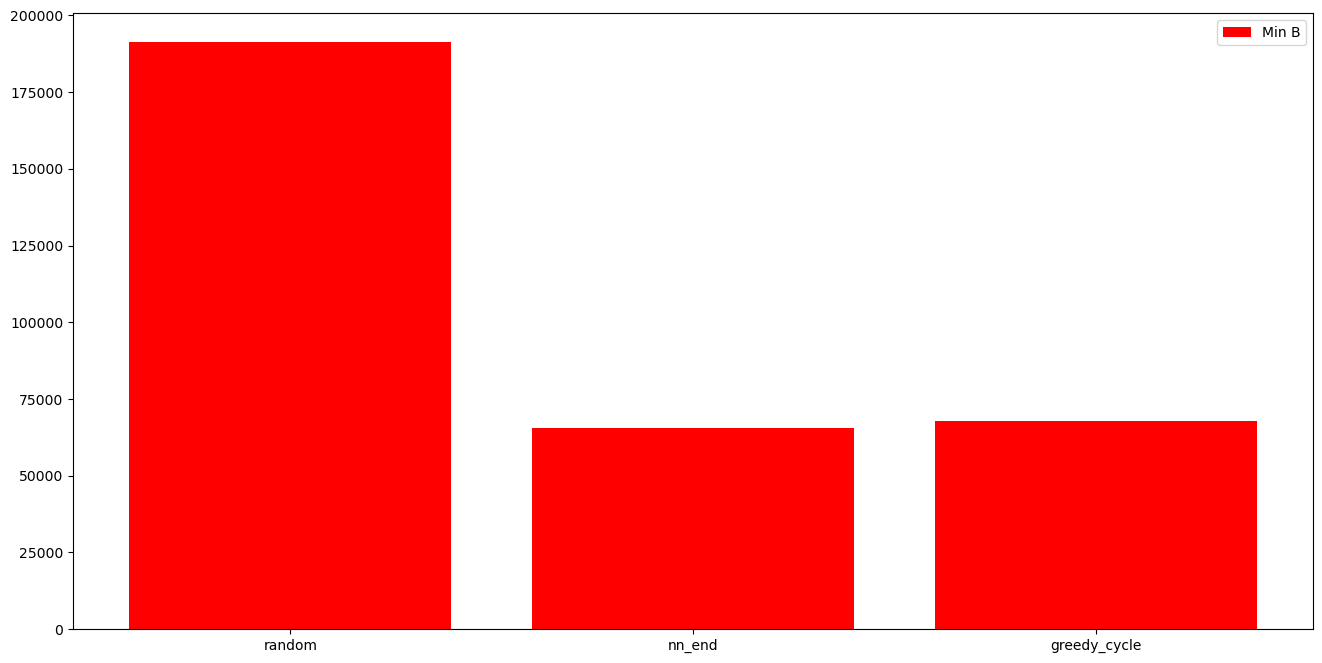

In [21]:

import pandas as pd
df = pd.read_csv('results.csv', header=None)
df.columns = ['Method', 'Instance', 'Min', 'Max', 'Avg']

display(df[df['Instance'] == 'A'])

display(df[df['Instance'] == 'B'])

# please make few plots to compare methods min, max, avg for each instance
# you can use matplotlib
import matplotlib.pyplot as plt

df_a = df[df['Instance'] == 'A']
df_b = df[df['Instance'] == 'B']

plt.figure(figsize=(16, 8))
plt.bar(df_a['Method'], df_a['Max'], color='blue', label='Max A')
plt.bar(df_a['Method'], df_a['Avg'], color='green', label='Avg A')
plt.bar(df_a['Method'], df_a['Min'], color='red', label='Min A')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.bar(df_b['Method'], df_b['Max'], color='blue', label='Max B')
plt.bar(df_b['Method'], df_b['Avg'], color='green', label='Avg B')
plt.bar(df_b['Method'], df_b['Min'], color='red', label='Min B')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.bar(df_b['Method'], df_b['Min'], color='red', label='Min B')
plt.legend()
plt.show()

# Characteristics of Instances

## Instance A

In [4]:
print("Average cost for an instance A:", np.mean(costs_a))

Average cost for an instance A: 978.165


## Instance B

In [5]:
print("Average cost for an instance B:", np.mean(costs_b))

Average cost for an instance B: 494.58


## Information whether the best solutions have been checked with the solution checker -> YES

# Conlusions:
- Nearest neighbor considering adding the node only at the end of the current path (NN_end) - method had best results for both instance, ended with best solution
- Random solution didn't have a luck even for such small sample of nodes and work much worse
- For an instance B, NN_end and greedy cycle method get amost same results
- Average cost for an instance is almost two times higher for instance B, which can be an explanation, why the results of heuristics give us lower overall cost
- In general, we expected:
    - nearest neighbor - be quick and far better than random
    - greedy cycle - balance between speed and solution quality
- We get nn_end even better than greedy cycle